This notebook contains the data processing and analyses for Flaherty, Sato & Kirby (2020). 

The following steps for pre-processing the data are not included in this notebook, as these involve the manipulation of confidential (e.g. video) data:

1. Transformation of kinect data by a scaling factor to enable comparison of body tracking data obtained from people with differing body sizes. All data was scaled using a scaling factor obtained from each participant's forearm length. 
2. Time-aligning of kinect data and video data for glossing
 


In [ ]:
try(setwd("/Users/Asha/Flaherty_Sato_Kirby_2020"))
list.files()

# two data sources: scaled kinect data for the whole session and glossed utterances with start and end frames.

body_data <- read.csv("whole_session_data_scaled.csv")
gloss <- read.csv("utterance_glosses.csv")


[1] "utterance_glosses.csv"            "whole_session_data_scaled.csv"   
[3] "whole_session_data_segmented.csv" "year_of_entry.csv"

In [ ]:
# looking at the glossed data

gloss <- gloss[order(gloss$Utt.number),] #re-order so utterances are in order. 
head(gloss,1)

# a typing error means the utterance numbers are not sequential:
# unique(gloss$Utt.number) 

# sequential utterance numbers are assigned in a new column (correspondence to number in original coding is preserved)
gloss$utterance_number <- factor(gloss$Utt.number)
levels(gloss$utterance_number) <- seq(1:length(unique(gloss$Utt.number)))


head(gloss$utterance_number)
tail(gloss$utterance_number)


In [ ]:
# looking at the body data 

head(body_data)

### Combining body data and glossed data


In [ ]:
# first we get a dataframe with utterance start and end points for each utterance
utterances <- as.data.frame(unique(cbind(id = gloss$Signer,  utterance_number = gloss$utterance_number, start_frame = gloss$Utterance..Utterance.Frame1, end_frame = gloss$Utterance..Utterance.last.frame)))

head(utterances,3)
tail(utterances,3)

In [ ]:
#give body dataframe a column with id that matches the one in utterances dataframe for merging
body_data$id <- as.numeric(substring(body_data$skeletonID,2))
head(body_data)

In [ ]:
# merge the two dataframes, using start and end frames from utterances to label frames with their utterance number or NA

m <- merge(body_data, do.call(rbind, apply(utterances, 1
  , function(x) cbind(id=x[1], utterance_number=x[2], frame=x[3]:x[4])))
 , all.x=TRUE)
    
m <- m[order(m$id),]
head(m)


In [ ]:
# add column specifying frame type (utterance or not)
m$is_utterance <- ifelse(is.na(m$utterance_number) == TRUE, 0,1)

# assign 'segment numbers'
# for utterances this is the utterance number
# for non-utterance segments this is taken from the adjacent utterance number.
require(zoo)
m$segment_number <- na.locf(m$utterance_number, na.rm = FALSE, by = list(m$id))  
m$segment_number <- na.locf(m$segment_number, na.rm = FALSE, by = list(m$id), fromLast = TRUE)

head(m,3)
tail(m,3)


In [40]:
# utterance 65 is excluded (71 in original coding) due to failure of the device
# keep NA
m <- subset(m, utterance_number != 65|is.na(utterance_number))


In [41]:
write.csv(m,"whole_session_data_segmented.csv", row.names = FALSE)

# BOUNDING BOX

In [187]:
try(setwd("/Users/Asha/Flaherty_Sato_Kirby_2020"))
list.files()

dat <- read.csv("whole_session_data_segmented.csv")

[1] "utterance_glosses.csv"            "whole_session_data_scaled.csv"   
[3] "whole_session_data_segmented.csv" "year_of_entry.csv"

In [188]:
head(dat)

frame,id,X,TimeStamp,skeletonID,HIP_CENTER_X,HIP_CENTER_Y,HIP_CENTER_Z,HIP_CENTER_TRACKSTATE,SPINE_X,⋯,HANDTIP_RIGHT_Z,HANDTIP_RIGHT_TRACKSTATE,THUMB_RIGHT_X,THUMB_RIGHT_Y,THUMB_RIGHT_Z,THUMB_RIGHT_TRACKSTATE,ppt,utterance_number,is_utterance,segment_number
1,27,95757,0,p27,1.0822322,47.14464,12.35252,2,0.1706741,⋯,65.84434,2,2.582145,-6.50609,55.91675,2,27,NA,0,538
2,27,95758,330000,p27,1.0267540,47.14464,12.31889,2,0.1706741,⋯,65.55738,2,2.582145,-6.50609,55.84663,2,27,NA,0,538
3,27,95759,660000,p27,0.9836366,47.14464,12.34791,2,0.1830348,⋯,65.25899,2,2.594505,-6.50609,55.77650,2,27,NA,0,538
4,27,95760,990000,p27,0.9959974,47.14464,12.41057,2,0.1953956,⋯,65.24757,2,2.606866,-6.50609,55.77650,2,27,NA,0,538
5,27,95761,1320000,p27,1.0083581,47.14464,12.49694,2,0.2077563,⋯,64.75792,2,3.358473,-6.50609,55.77650,2,27,NA,0,538
6,27,95762,1650000,p27,1.0083581,47.14464,12.52066,2,0.2077563,⋯,64.27970,2,4.097719,-6.50609,55.77650,2,27,NA,0,538


In [189]:
cat("number of frames in dataset:")
nrow(dat)

cat("number of frames coded as utterances:")
nrow(subset(dat, is.na(dat$utterance_number)))

cat("number of frames not coded as utterances:")
nrow(subset(dat, !is.na(dat$utterance_number)))


number of frames in dataset:

[1] 238253

number of frames coded as utterances:

[1] 140955

number of frames not coded as utterances:

[1] 97298

## getting the bounding box

In [190]:
#empty vectors to store length, height, width, volume, box centre X Y and Z, frame type
id_vec <- c()

length_vec <- c()
height_vec <- c()
width_vec <- c()

volume_vec <- c()

centX_vec <- c()
centY_vec <- c()
centZ_vec <- c()

frame_type_vec <- c()

options(warn= -1)

#loop over signer IDs calculating the above and adding to them to the vector 

for (s in seq(1:length(unique(dat$skeletonID)))) {
    
    iD <- as.character(unique(dat$skeletonID)[s])
    
    #grab this signer's utterance data
    frame_type <- "UTT"
    df <- subset(dat, skeletonID == iD & is_utterance == 1)
    
    #get mins and max wrist positions
    minX <- min(c(df$WRIST_LEFT_X, df$WRIST_RIGHT_X))
    minY <- min(c(df$WRIST_LEFT_Y, df$WRIST_RIGHT_Y))
    minZ <- min(c(df$WRIST_LEFT_Z, df$WRIST_RIGHT_Z))
        
    maxX <- max(c(df$WRIST_LEFT_X, df$WRIST_RIGHT_X))
    maxY <- max(c(df$WRIST_LEFT_Y, df$WRIST_RIGHT_Y))
    maxZ <- max(c(df$WRIST_LEFT_Z, df$WRIST_RIGHT_Z))

    #get box dimensions
    length <- maxX - minX
    height <- maxY - minY
    width <- maxZ - minZ
    
    #get centre of the box
    cX <- (minX+maxX)/2
    cY <- (minY+maxY)/2
    cZ <- (minZ+maxZ)/2
    
    #store in vectors
    id_vec <- c(id_vec, iD)
    length_vec <- c(length_vec, length)
    height_vec <- c(height_vec, height)
    width_vec <- c(width_vec, width)
    centX_vec <- c(centX_vec, cX)
    centY_vec <- c(centY_vec, cY)
    centZ_vec <- c(centZ_vec, cZ)
    frame_type_vec <-c(frame_type_vec, frame_type)
    
       #grab this signer's non-utterance data
    
    frame_type <- "NON_UTT"
    df <- subset(dat, skeletonID == iD & is_utterance == 0)
    
    #get mins and max wrist positions
    minX <- min(c(df$WRIST_LEFT_X, df$WRIST_RIGHT_X))
    minY <- min(c(df$WRIST_LEFT_Y, df$WRIST_RIGHT_Y))
    minZ <- min(c(df$WRIST_LEFT_Z, df$WRIST_RIGHT_Z))
        
    maxX <- max(c(df$WRIST_LEFT_X, df$WRIST_RIGHT_X))
    maxY <- max(c(df$WRIST_LEFT_Y, df$WRIST_RIGHT_Y))
    maxZ <- max(c(df$WRIST_LEFT_Z, df$WRIST_RIGHT_Z))

    #get box dimensions
    length <- maxX - minX
    height <- maxY - minY
    width <- maxZ - minZ
    
    #get centre of the box
    cX <- (minX+maxX)/2
    cY <- (minY+maxY)/2
    cZ <- (minZ+maxZ)/2
    
    #store in vectors
    id_vec <- c(id_vec, iD)
    length_vec <- c(length_vec, length)
    height_vec <- c(height_vec, height)
    width_vec <- c(width_vec, width)
    centX_vec <- c(centX_vec, cX)
    centY_vec <- c(centY_vec, cY)
    centZ_vec <- c(centZ_vec, cZ)
    frame_type_vec <-c(frame_type_vec, frame_type)

}

bbox <- data.frame(Signer = substr(as.character(id_vec),2,nchar(as.character(id_vec))),
                  length = length_vec,
                  height = height_vec,
                  width = width_vec,
                  box_centre_X = centX_vec,
                  box_centre_Y = centY_vec,
                  box_centre_Z = centZ_vec,
                  frame_type = frame_type_vec)

bbox$volume_cm3 <- bbox$length*bbox$width*bbox$height
bbox$volume_m3 <- bbox$volume_cm3*.000001


In [191]:
#merge with Year of Entry
YoE <- read.csv("year_of_entry.csv")
bbox <- merge(bbox, YoE)

head(bbox)

Signer,length,height,width,box_centre_X,box_centre_Y,box_centre_Z,frame_type,volume_cm3,volume_m3,cohort,YoE
145,74.97041,73.30391,59.26377,2.494496,18.06795,25.07587,UTT,325691.4,0.3256914,2,1990
145,68.30357,73.11799,55.75540,6.981250,18.62372,18.66881,NON_UTT,278454.7,0.2784547,2,1990
158,73.13590,59.45122,53.15132,-2.990366,16.61637,30.34246,UTT,231102.9,0.2311029,2,1986
158,48.00842,60.55909,50.65950,1.598662,16.59169,29.13044,NON_UTT,147284.7,0.1472847,2,1986
159,78.39847,60.72945,49.86867,-3.222411,21.69983,32.39669,UTT,237429.5,0.2374295,2,1986
159,99.31596,85.97514,56.54239,-5.815334,12.91198,20.19784,NON_UTT,482798.6,0.4827986,2,1986


In [192]:
#re-name frame type levels
#levels(bbox$frame_type)
levels(bbox$frame_type) <- c("Non utterance", "Utterance")

In [193]:
# save bounding box dataframe
# write.csv(bbox,"bounding_box_data.csv")

In [207]:
cat("max volume:")
max(bbox$volume_m3)

cat("min volume:")
min(bbox$volume_m3)

max volume:

[1] 0.7915275

min volume:

[1] 0.08446487

bounding box by year of entry

Saving 7 x 7 in image


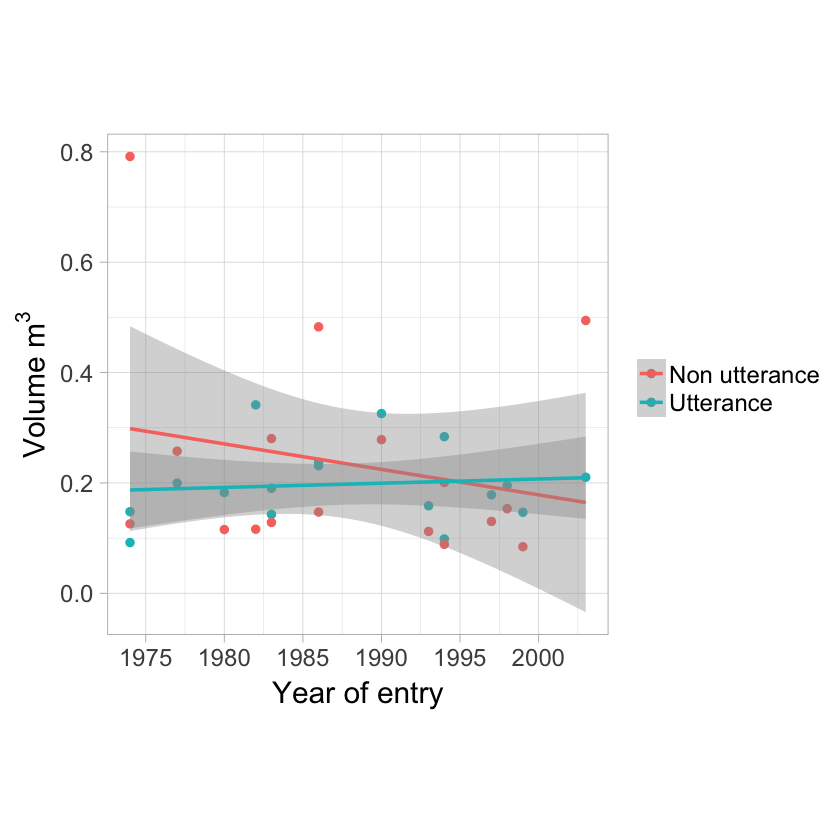

In [219]:
require(ggplot2)

cat("bounding box by year of entry")

p <- ggplot(bbox, aes(x = YoE, y = volume_m3, color = frame_type))+
geom_point(size = 2)+
geom_smooth(method = "lm")+
scale_x_continuous(breaks = seq(1970,2005,by = 5))+
xlab("Year of entry")+
ylab(expression(paste("Volume ", m^{3})))+
theme_light(base_size = 18)+
theme(legend.title = element_blank(), aspect.ratio=1)

p
ggsave("plots/bounding_box_plot.jpeg", p)

In [197]:
require(lme4)

#predictor variable is centered so intercept is the earliest year of entry in our dataset. 
bbox$YoE_centered <- bbox$YoE - min(bbox$YoE)
summary(lm(volume_m3 ~ YoE_centered + frame_type, data = bbox))


Call:
lm(formula = volume_m3 ~ YoE_centered + frame_type, data = bbox)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.13535 -0.09000 -0.02560  0.03639  0.53031 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)          0.261221   0.052651   4.961  2.4e-05 ***
YoE_centered        -0.001924   0.002839  -0.678    0.503    
frame_typeUtterance -0.036777   0.049630  -0.741    0.464    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1447 on 31 degrees of freedom
Multiple R-squared:  0.0315,	Adjusted R-squared:  -0.03098 
F-statistic: 0.5042 on 2 and 31 DF,  p-value: 0.6089


## DISTANCE  (BODY-WRIST)

In [198]:
try(setwd("/Users/Asha/Flaherty_Sato_Kirby_2020"))
list.files()

[1] "bounding_box_data.csv"            "plots"                           
[3] "utterance_glosses.csv"            "whole_session_data_scaled.csv"   
[5] "whole_session_data_segmented.csv" "year_of_entry.csv"

In [199]:
body_data <- read.csv("whole_session_data_segmented.csv")
head(body_data,3)

frame,id,X,TimeStamp,skeletonID,HIP_CENTER_X,HIP_CENTER_Y,HIP_CENTER_Z,HIP_CENTER_TRACKSTATE,SPINE_X,⋯,HANDTIP_RIGHT_Z,HANDTIP_RIGHT_TRACKSTATE,THUMB_RIGHT_X,THUMB_RIGHT_Y,THUMB_RIGHT_Z,THUMB_RIGHT_TRACKSTATE,ppt,utterance_number,is_utterance,segment_number
1,27,95757,0,p27,1.0822322,47.14464,12.35252,2,0.1706741,⋯,65.84434,2,2.582145,-6.50609,55.91675,2,27,NA,0,538
2,27,95758,330000,p27,1.0267540,47.14464,12.31889,2,0.1706741,⋯,65.55738,2,2.582145,-6.50609,55.84663,2,27,NA,0,538
3,27,95759,660000,p27,0.9836366,47.14464,12.34791,2,0.1830348,⋯,65.25899,2,2.594505,-6.50609,55.77650,2,27,NA,0,538


In [200]:
# body-wrist distance is calculated from the origin (0,0,0) of the body data. 
# This corresponds to the Kinect SHOULDER_CENTER tracked joint between the shoulders.

# Pythagoras -the distance d between two points a and b in 3D space is given by
# d = sqrt((ax-bx)^2+(ay-by)^2+(az-bz)^2) 



body_data$left_body_wrist_dist <- sqrt( (body_data$WRIST_LEFT_X - body_data$SHOULDER_CENTER_X)^2 +
                                      (body_data$WRIST_LEFT_Y - body_data$SHOULDER_CENTER_Y)^2+
                                      (body_data$WRIST_LEFT_Z - body_data$SHOULDER_CENTER_Z)^2 )

body_data$right_body_wrist_dist <- sqrt( (body_data$WRIST_RIGHT_X - body_data$SHOULDER_CENTER_X)^2 +
                                      (body_data$WRIST_RIGHT_Y - body_data$SHOULDER_CENTER_Y)^2+
                                      (body_data$WRIST_RIGHT_Z - body_data$SHOULDER_CENTER_Z)^2 )



head(body_data,3)

frame,id,X,TimeStamp,skeletonID,HIP_CENTER_X,HIP_CENTER_Y,HIP_CENTER_Z,HIP_CENTER_TRACKSTATE,SPINE_X,⋯,THUMB_RIGHT_X,THUMB_RIGHT_Y,THUMB_RIGHT_Z,THUMB_RIGHT_TRACKSTATE,ppt,utterance_number,is_utterance,segment_number,left_body_wrist_dist,right_body_wrist_dist
1,27,95757,0,p27,1.0822322,47.14464,12.35252,2,0.1706741,⋯,2.582145,-6.50609,55.91675,2,27,NA,0,538,52.41598,42.39771
2,27,95758,330000,p27,1.0267540,47.14464,12.31889,2,0.1706741,⋯,2.582145,-6.50609,55.84663,2,27,NA,0,538,51.76476,42.32824
3,27,95759,660000,p27,0.9836366,47.14464,12.34791,2,0.1830348,⋯,2.594505,-6.50609,55.77650,2,27,NA,0,538,51.18707,42.26046


In [201]:
# get average distance of the wrists from origin

body_data$mean_body_wrist_dist <-rowMeans(body_data[,c("left_body_wrist_dist", "right_body_wrist_dist")])
head(body_data,3)

frame,id,X,TimeStamp,skeletonID,HIP_CENTER_X,HIP_CENTER_Y,HIP_CENTER_Z,HIP_CENTER_TRACKSTATE,SPINE_X,⋯,THUMB_RIGHT_Y,THUMB_RIGHT_Z,THUMB_RIGHT_TRACKSTATE,ppt,utterance_number,is_utterance,segment_number,left_body_wrist_dist,right_body_wrist_dist,mean_body_wrist_dist
1,27,95757,0,p27,1.0822322,47.14464,12.35252,2,0.1706741,⋯,-6.50609,55.91675,2,27,NA,0,538,52.41598,42.39771,47.40684
2,27,95758,330000,p27,1.0267540,47.14464,12.31889,2,0.1706741,⋯,-6.50609,55.84663,2,27,NA,0,538,51.76476,42.32824,47.04650
3,27,95759,660000,p27,0.9836366,47.14464,12.34791,2,0.1830348,⋯,-6.50609,55.77650,2,27,NA,0,538,51.18707,42.26046,46.72376


In [202]:
# aggregate body wrist distance by segment

body_data$is_utterance <- as.factor(body_data$is_utterance)

#utterance data 
utterance_distances <- aggregate(subset(body_data, is_utterance == 1)[,c("left_body_wrist_dist", "right_body_wrist_dist", "mean_body_wrist_dist")], by = list(subset(body_data, is_utterance == 1)$id, subset(body_data, is_utterance == 1)$segment_number), FUN = mean)
colnames(utterance_distances) <- c("Signer", "segment_number", "left_body_wrist_dist", "right_body_wrist_dist", "mean_body_wrist_dist")
utterance_distances$is_utterance <- "Utterance"
# head(utterance_distances)
# nrow(utterance_distances)

#non-utterance data
non_utterance_distances <- aggregate(subset(body_data, is_utterance == 0)[,c("left_body_wrist_dist", "right_body_wrist_dist", "mean_body_wrist_dist")], by = list(subset(body_data, is_utterance == 0)$id, subset(body_data, is_utterance == 0)$segment_number), FUN = mean)
colnames(non_utterance_distances) <- c("Signer", "segment_number", "left_body_wrist_dist", "right_body_wrist_dist", "mean_body_wrist_dist")
non_utterance_distances$is_utterance <- "Non Utterance"
# head(non_utterance_distances)
# nrow(non_utterance_distances)

#join
body_wrist_distances <- rbind(utterance_distances, non_utterance_distances)
head(body_wrist_distances,3)
tail(body_wrist_distances, 3)

Signer,segment_number,left_body_wrist_dist,right_body_wrist_dist,mean_body_wrist_dist,is_utterance
145,1,39.86827,39.19539,39.53183,Utterance
145,2,40.21379,45.15840,42.68610,Utterance
145,3,39.76624,41.71999,40.74311,Utterance


,Signer,segment_number,left_body_wrist_dist,right_body_wrist_dist,mean_body_wrist_dist,is_utterance
1148,27,570,48.67766,45.08866,46.88316,Non Utterance
1149,27,571,45.27871,46.66398,45.97134,Non Utterance
1150,36,571,52.26955,53.52085,52.89520,Non Utterance


In [203]:
#merge with Year of Entry
YoE <- read.csv("year_of_entry.csv")
body_wrist_distances <- merge(YoE,body_wrist_distances)
head(body_wrist_distances,3)

Signer,cohort,YoE,segment_number,left_body_wrist_dist,right_body_wrist_dist,mean_body_wrist_dist,is_utterance
27,1,1977,557,52.16559,50.46256,51.31407,Non Utterance
27,1,1977,571,41.82662,44.43284,43.12973,Utterance
27,1,1977,539,51.37429,49.12567,50.24998,Utterance


In [209]:
#write.csv(body_wrist_distances, "body_wrist_distances.csv")

In [211]:
cat("min distance:")
min(body_wrist_distances$mean_body_wrist_dist)

cat("max distance:")
max(body_wrist_distances$mean_body_wrist_dist)

min distance:

[1] 23.11704

max distance:

[1] 56.54722

In [224]:
body_wrist_distances[order(body_wrist_distances$mean_body_wrist_dist),]

,Signer,cohort,YoE,segment_number,left_body_wrist_dist,right_body_wrist_dist,mean_body_wrist_dist,is_utterance,YoE_centered
168,41,1,1974,302,23.88060,22.35349,23.11704,Non Utterance,0
1068,420,3,1999,259,21.50735,25.08338,23.29536,Utterance,25
520,191,1,1983,119,20.07427,29.26891,24.67159,Utterance,9
691,264,3,1994,371,28.26216,28.93004,28.59610,Utterance,20
717,264,3,1994,385,28.14682,29.53658,28.84170,Utterance,20
1028,420,3,1999,248,25.40445,33.31104,29.35774,Utterance,25
699,264,3,1994,392,25.43746,33.33454,29.38600,Utterance,20
683,264,3,1994,372,27.96448,31.42671,29.69559,Utterance,20
675,264,3,1994,374,29.49257,30.11337,29.80297,Utterance,20
685,264,3,1994,391,30.18796,30.05726,30.12261,Utterance,20


body wrist distance by year of entry

Saving 7 x 7 in image


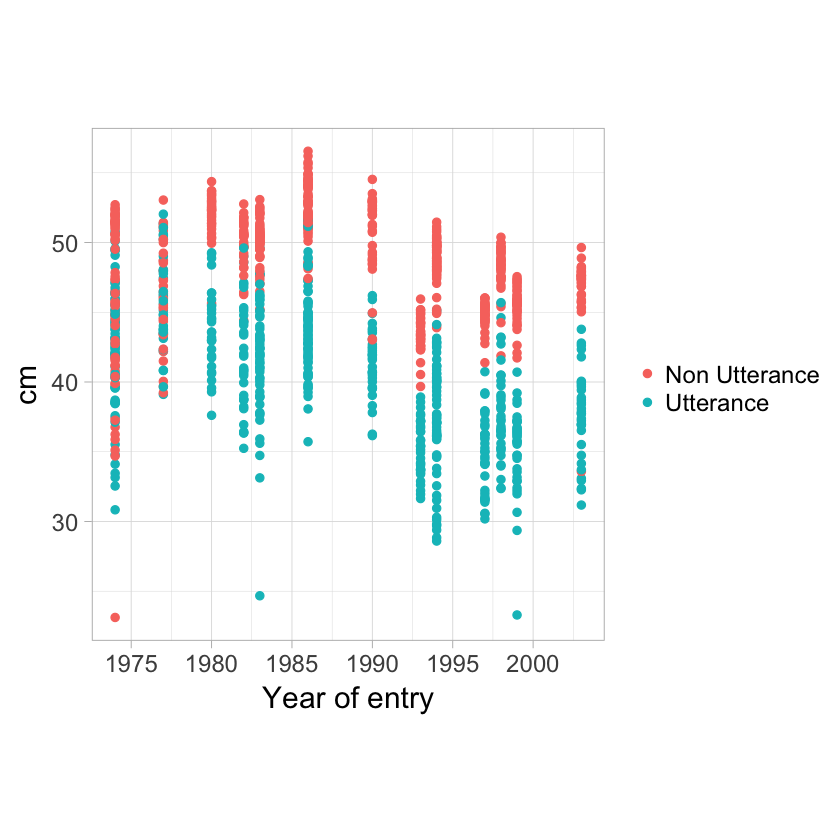

In [221]:
require(ggplot2)

cat("body wrist distance by year of entry")

p <- ggplot(body_wrist_distances, aes(x = YoE, y = mean_body_wrist_dist, color = is_utterance))+
geom_point(size = 2)+
# geom_smooth(method = "lm")+
scale_x_continuous(breaks = seq(1970,2005,by = 5))+
xlab("Year of entry")+
ylab("cm")+
theme_light(base_size = 18)+
theme(legend.title = element_blank(), aspect.ratio=1)

p
ggsave("plots/bw_distance_plot.jpeg", p)

In [213]:
#stats

require("lme4")

#predictor variable is centered so intercept is the earliest year of entry in our dataset. 
body_wrist_distances$YoE_centered <- body_wrist_distances$YoE - min(body_wrist_distances$YoE)

full_mdl <- lmer(mean_body_wrist_dist ~ YoE_centered + is_utterance +  YoE_centered:is_utterance +(1|Signer), data = body_wrist_distances)
mdl <- lmer(mean_body_wrist_dist ~ YoE_centered + is_utterance +(1|Signer), data = body_wrist_distances)

YoE_only <- lmer(mean_body_wrist_dist ~ YoE_centered +(1|Signer), data = body_wrist_distances)
frame_type_only <- lmer(mean_body_wrist_dist ~ is_utterance +(1|Signer), data = body_wrist_distances)

null_mdl <- lmer(mean_body_wrist_dist ~ (1|Signer), data = body_wrist_distances)

summary(full_mdl)

cat("overall")
anova(full_mdl, null_mdl)

cat("effect of interaction?")
anova(full_mdl, mdl)

cat("main effect of frame type?")
anova(full_mdl, YoE_only)

cat("main effect of YoE?")
anova(full_mdl, frame_type_only)



Linear mixed model fit by REML ['lmerMod']
Formula: 
mean_body_wrist_dist ~ YoE_centered + is_utterance + YoE_centered:is_utterance +  
    (1 | Signer)
   Data: body_wrist_distances

REML criterion at convergence: 5853.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-9.0036 -0.4916  0.0895  0.5708  2.8785 

Random effects:
 Groups   Name        Variance Std.Dev.
 Signer   (Intercept) 7.340    2.709   
 Residual             8.909    2.985   
Number of obs: 1150, groups:  Signer, 17

Fixed effects:
                                   Estimate Std. Error t value
(Intercept)                        49.33333    1.25224   39.40
YoE_centered                       -0.07054    0.07652   -0.92
is_utteranceUtterance              -4.64414    0.33424  -13.89
YoE_centered:is_utteranceUtterance -0.24967    0.02016  -12.38

Correlation of Fixed Effects:
            (Intr) YE_cnt is_ttU
YoE_centerd -0.845              
is_ttrncUtt -0.134  0.112       
YE_cntrd:_U  0.114 -0.131 -0.850

overall

refitting model(s) with ML (instead of REML)


,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
null_mdl,3,7113.265,7128.408,-3553.633,7107.265,NA,NA,NA
full_mdl,6,5855.134,5885.419,-2921.567,5843.134,1264.131,3,8.923991e-274


effect of interaction?

refitting model(s) with ML (instead of REML)


,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
mdl,5,5997.210,6022.447,-2993.605,5987.210,NA,NA,NA
full_mdl,6,5855.134,5885.419,-2921.567,5843.134,144.0755,1,3.420483e-33


main effect of frame type?

refitting model(s) with ML (instead of REML)


,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
YoE_only,4,7109.312,7129.502,-3550.656,7101.312,NA,NA,NA
full_mdl,6,5855.134,5885.419,-2921.567,5843.134,1258.178,2,6.168913e-274


main effect of YoE?

refitting model(s) with ML (instead of REML)


,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
frame_type_only,4,6001.394,6021.584,-2996.697,5993.394,NA,NA,NA
full_mdl,6,5855.134,5885.419,-2921.567,5843.134,150.2603,2,2.351755e-33


## DISTANCE  (MEAN POSITION OF THE WRISTS)

In [157]:
# find the mean position of the wrists of each signer over the whole session, 
# we also get the mean position of the wrists separately for utterance data and non-utterance data
# as we expect these to be differently distributed

#empty vectors for storing values
ids <- c()
mean_x_pos <- c()
mean_y_pos <- c()
mean_z_pos <- c()

utt_x_pos <- c()
utt_y_pos <- c()
utt_z_pos <- c()

non_utt_x_pos <- c()
non_utt_y_pos <- c()
non_utt_z_pos <- c()

#colnames(body_data)
for (signer in unique(body_data$id)) {
    iD <- signer
#      print(iD)
     df <- subset(body_data, ppt == iD)
    
     #whole session mean positions:
    
     mean_x <- mean(c(df$WRIST_LEFT_X, df$WRIST_RIGHT_X))
     mean_y <- mean(c(df$WRIST_LEFT_Y, df$WRIST_RIGHT_Y))
     mean_z <- mean(c(df$WRIST_LEFT_Z, df$WRIST_RIGHT_Z))
    
     utt_x <- mean(c(subset(df, is_utterance == 1)$WRIST_LEFT_X, (subset(df, is_utterance == 1)$WRIST_RIGHT_X)))
     utt_y <- mean(c(subset(df, is_utterance == 1)$WRIST_LEFT_Y, (subset(df, is_utterance == 1)$WRIST_RIGHT_Y)))
     utt_z <- mean(c(subset(df, is_utterance == 1)$WRIST_LEFT_Z, (subset(df, is_utterance == 1)$WRIST_RIGHT_Z)))

     non_utt_x <- mean(c(subset(df, is_utterance == 0)$WRIST_LEFT_X, (subset(df, is_utterance == 0)$WRIST_RIGHT_X)))
     non_utt_y <- mean(c(subset(df, is_utterance == 0)$WRIST_LEFT_Y, (subset(df, is_utterance == 0)$WRIST_RIGHT_Y)))
     non_utt_z <- mean(c(subset(df, is_utterance == 0)$WRIST_LEFT_Z, (subset(df, is_utterance == 0)$WRIST_RIGHT_Z)))
   
                   
#     #add to vectors
    ids <- c(ids, iD)
    
    mean_x_pos <- c(mean_x_pos, mean_x)
    mean_y_pos <- c(mean_y_pos, mean_y)
    mean_z_pos <- c(mean_z_pos, mean_z)
    
    utt_x_pos <- c(utt_x_pos, utt_x)
    utt_y_pos <- c(utt_y_pos, utt_y)
    utt_z_pos <- c(utt_z_pos, utt_z)

    non_utt_x_pos <- c(non_utt_x_pos, non_utt_x)
    non_utt_y_pos <- c(non_utt_y_pos, non_utt_y)
    non_utt_z_pos <- c(non_utt_z_pos, non_utt_z)
      
}

mean_wrist_positions <- as.data.frame(cbind("Signer" = ids, 
                                            "mean_x" = mean_x_pos,
                                           "mean_y" = mean_y_pos,
                                           "mean_z" = mean_z_pos,
                                           "utt_mean_x" = utt_x_pos,
                                           "utt_mean_y" = utt_y_pos,
                                           "utt_mean_z" = utt_z_pos,
                                           "non_utt_mean_x" = non_utt_x_pos,
                                           "non_utt_mean_y" = non_utt_y_pos,
                                           "non_utt_mean_z" = non_utt_z_pos
                                           ))

head(mean_wrist_positions)


Signer,mean_x,mean_y,mean_z,utt_mean_x,utt_mean_y,utt_mean_z,non_utt_mean_x,non_utt_mean_y,non_utt_mean_z
27,3.4841348,29.60389,30.42871,3.43840633,29.07597,30.47875,3.5273539,30.10284,30.38141
36,1.6544830,36.43440,26.74215,1.16393488,28.72018,27.60861,1.8803037,39.98559,26.34328
41,-0.6666407,30.50464,30.64336,-0.84180809,26.39725,33.58869,-0.4971052,34.47996,27.79274
49,0.2940719,30.18718,28.85032,-0.04722237,17.49275,32.55606,0.5206075,38.61316,26.39061
145,3.4719842,30.91175,28.49754,3.87954259,19.44281,29.95835,3.2204451,37.99021,27.59595
158,0.1432539,35.71954,24.83047,-1.35495970,28.33478,26.63402,1.3089446,41.46528,23.42721


In [183]:
# note that the mean position (height) of the wrists is significantly different for utterance data and non-utterance data:
t.test(mean_wrist_positions$utt_mean_y, mean_wrist_positions$non_utt_mean_y)


	Welch Two Sample t-test

data:  mean_wrist_positions$utt_mean_y and mean_wrist_positions$non_utt_mean_y
t = -8.3147, df = 30.893, p-value = 2.22e-09
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -18.41195 -11.15774
sample estimates:
mean of x mean of y 
 21.19877  35.98362 


In [165]:
# merge with Year of Entry
YoE <- read.csv("year_of_entry.csv")
mean_wrist_positions <- merge(YoE,mean_wrist_positions)
head(mean_wrist_positions,3)

Signer,cohort,YoE,mean_x,mean_y,mean_z,utt_mean_x,utt_mean_y,utt_mean_z,non_utt_mean_x,non_utt_mean_y,non_utt_mean_z
145,2,1990,3.4719842,30.91175,28.49754,3.879543,19.44281,29.95835,3.220445,37.99021,27.59595
158,2,1986,0.1432539,35.71954,24.83047,-1.354960,28.33478,26.63402,1.308945,41.46528,23.42721
159,2,1986,-0.1671840,35.53934,27.61010,1.216591,26.21596,30.29413,-1.152503,42.17807,25.69894


In [175]:
# merge mean positions into body data

body_data <- merge(body_data, mean_wrist_positions, by.x = "id", by.y = "Signer")
head(body_data,3)

id,frame,X,TimeStamp,skeletonID,HIP_CENTER_X,HIP_CENTER_Y,HIP_CENTER_Z,HIP_CENTER_TRACKSTATE,SPINE_X,⋯,YoE,mean_x,mean_y,mean_z,utt_mean_x,utt_mean_y,utt_mean_z,non_utt_mean_x,non_utt_mean_y,non_utt_mean_z
27,1,95757,0,p27,1.0822322,47.14464,12.35252,2,0.1706741,⋯,1977,3.484135,29.60389,30.42871,3.438406,29.07597,30.47875,3.527354,30.10284,30.38141
27,2,95758,330000,p27,1.0267540,47.14464,12.31889,2,0.1706741,⋯,1977,3.484135,29.60389,30.42871,3.438406,29.07597,30.47875,3.527354,30.10284,30.38141
27,3,95759,660000,p27,0.9836366,47.14464,12.34791,2,0.1830348,⋯,1977,3.484135,29.60389,30.42871,3.438406,29.07597,30.47875,3.527354,30.10284,30.38141


In [176]:
# frame by frame distance to mean wrist position (whole session mean)

# Pythagoras -the distance d between two points a and b in 3D space is given by
# d = sqrt((ax-bx)^2+(ay-by)^2+(az-bz)^2) 

body_data$left_mp_dist <- sqrt( (body_data$WRIST_LEFT_X - body_data$mean_x)^2 +
                                      (body_data$WRIST_LEFT_Y - body_data$mean_y)^2+
                                      (body_data$WRIST_LEFT_Z - body_data$mean_z)^2 )

body_data$right_mp_dist <- sqrt( (body_data$WRIST_RIGHT_X - body_data$mean_x)^2 +
                                      (body_data$WRIST_RIGHT_Y - body_data$mean_y)^2+
                                      (body_data$WRIST_RIGHT_Z - body_data$mean_z)^2 )

head(body_data,3)

id,frame,X,TimeStamp,skeletonID,HIP_CENTER_X,HIP_CENTER_Y,HIP_CENTER_Z,HIP_CENTER_TRACKSTATE,SPINE_X,⋯,mean_y,mean_z,utt_mean_x,utt_mean_y,utt_mean_z,non_utt_mean_x,non_utt_mean_y,non_utt_mean_z,left_mp_dist,right_mp_dist
27,1,95757,0,p27,1.0822322,47.14464,12.35252,2,0.1706741,⋯,29.60389,30.42871,3.438406,29.07597,30.47875,3.527354,30.10284,30.38141,25.35109,32.17484
27,2,95758,330000,p27,1.0267540,47.14464,12.31889,2,0.1706741,⋯,29.60389,30.42871,3.438406,29.07597,30.47875,3.527354,30.10284,30.38141,24.84583,32.14968
27,3,95759,660000,p27,0.9836366,47.14464,12.34791,2,0.1830348,⋯,29.60389,30.42871,3.438406,29.07597,30.47875,3.527354,30.10284,30.38141,24.36886,32.12554


In [177]:
# get average distance to mean position

body_data$mean_mp_dist <-rowMeans(body_data[,c("left_mp_dist", "right_mp_dist")])
head(body_data,3)

id,frame,X,TimeStamp,skeletonID,HIP_CENTER_X,HIP_CENTER_Y,HIP_CENTER_Z,HIP_CENTER_TRACKSTATE,SPINE_X,⋯,mean_z,utt_mean_x,utt_mean_y,utt_mean_z,non_utt_mean_x,non_utt_mean_y,non_utt_mean_z,left_mp_dist,right_mp_dist,mean_mp_dist
27,1,95757,0,p27,1.0822322,47.14464,12.35252,2,0.1706741,⋯,30.42871,3.438406,29.07597,30.47875,3.527354,30.10284,30.38141,25.35109,32.17484,28.76297
27,2,95758,330000,p27,1.0267540,47.14464,12.31889,2,0.1706741,⋯,30.42871,3.438406,29.07597,30.47875,3.527354,30.10284,30.38141,24.84583,32.14968,28.49776
27,3,95759,660000,p27,0.9836366,47.14464,12.34791,2,0.1830348,⋯,30.42871,3.438406,29.07597,30.47875,3.527354,30.10284,30.38141,24.36886,32.12554,28.24720


In [180]:
# aggregate distance to mean position by segment 

body_data$is_utterance <- as.factor(body_data$is_utterance)

#utterance data 
utterance_distances <- aggregate(subset(body_data, is_utterance == 1)[,c("left_mp_dist", "right_mp_dist", "mean_mp_dist")], by = list(subset(body_data, is_utterance == 1)$id, subset(body_data, is_utterance == 1)$segment_number), FUN = mean)
colnames(utterance_distances) <- c("Signer", "segment_number", "left_mp_dist", "right_mp_dist", "mean_mp_dist")
utterance_distances$is_utterance <- "Utterance"
# head(utterance_distances)
# nrow(utterance_distances)

#non-utterance data
non_utterance_distances <- aggregate(subset(body_data, is_utterance == 0)[,c("left_mp_dist", "right_mp_dist", "mean_mp_dist")], by = list(subset(body_data, is_utterance == 0)$id, subset(body_data, is_utterance == 0)$segment_number), FUN = mean)
colnames(non_utterance_distances) <- c("Signer", "segment_number", "left_mp_dist", "right_mp_dist", "mean_mp_dist")
non_utterance_distances$is_utterance <- "Non Utterance"
# head(non_utterance_distances)
# nrow(non_utterance_distances)

#join
mp_distances <- rbind(utterance_distances, non_utterance_distances)
mp_distances <- merge(mp_distances, YoE)
head(mp_distances,3)
tail(mp_distances, 3)

Signer,segment_number,left_mp_dist,right_mp_dist,mean_mp_dist,is_utterance,cohort,YoE
27,553,14.59661,18.36058,16.47860,Utterance,1,1977
27,554,12.85395,15.35232,14.10313,Utterance,1,1977
27,557,14.68874,23.02538,18.85706,Utterance,1,1977


,Signer,segment_number,left_mp_dist,right_mp_dist,mean_mp_dist,is_utterance,cohort,YoE
1148,736,60,16.76981,12.76880,14.76931,Non Utterance,4,2003
1149,736,263,14.05042,13.59497,13.82269,Non Utterance,4,2003
1150,736,53,14.03547,13.82564,13.93055,Non Utterance,4,2003


In [217]:
cat("min distance:")
min(mp_distances$mean_mp_dist)

cat("max distance:")
max(mp_distances$mean_mp_dist)

min distance:

[1] 12.58294

max distance:

[1] 38.41431

distance to mean position of wrists by year of entry

Saving 7 x 7 in image


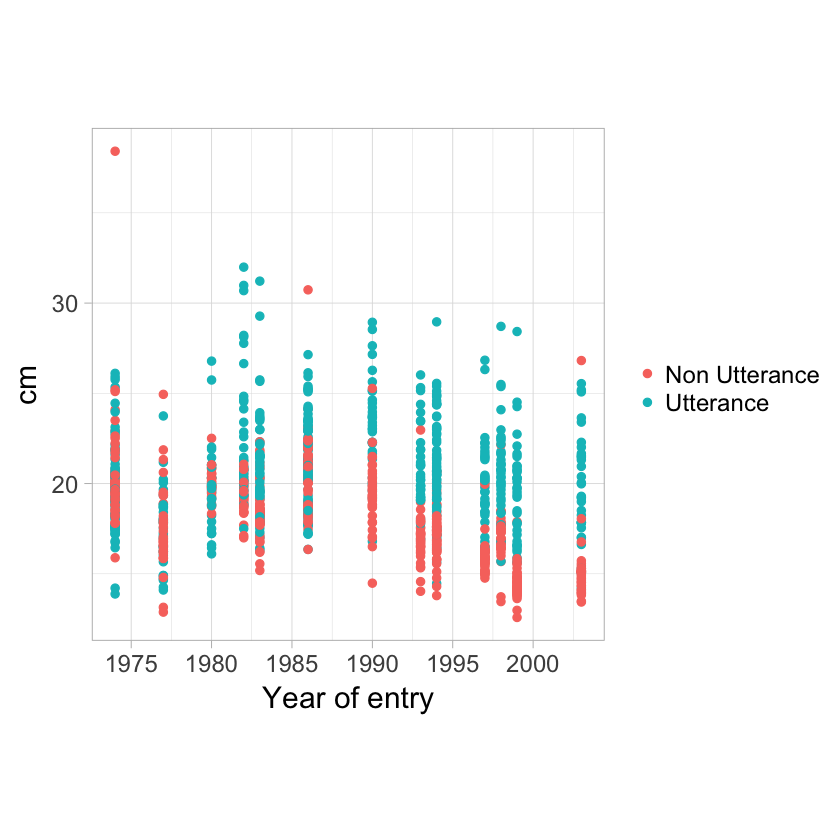

In [220]:
require(ggplot2)

cat("distance to mean position of wrists by year of entry")

p <- ggplot(mp_distances, aes(x = YoE, y = mean_mp_dist, color = is_utterance))+
geom_point(size = 2)+
scale_x_continuous(breaks = seq(1970,2005,by = 5))+
xlab("Year of entry")+
ylab("cm")+
theme_light(base_size = 18)+
theme(legend.title = element_blank(), aspect.ratio=1)

p
ggsave("mp_distance_plot.jpeg", p)

In [218]:
#stats

require("lme4")

#predictor variable is centered so intercept is the earliest year of entry in our dataset. 
mp_distances$YoE_centered <- mp_distances$YoE - min(mp_distances$YoE)

full_mdl <- lmer(mean_mp_dist ~ YoE_centered + is_utterance +  YoE_centered:is_utterance +(1|Signer), data = mp_distances)
mdl <- lmer(mean_mp_dist ~ YoE_centered + is_utterance +(1|Signer), data = mp_distances)

YoE_only <- lmer(mean_mp_dist ~ YoE_centered +(1|Signer), data = mp_distances)
frame_type_only <- lmer(mean_mp_dist ~ is_utterance +(1|Signer), data = mp_distances)

null_mdl <- lmer(mean_mp_dist ~ (1|Signer), data = mp_distances)

summary(full_mdl)

cat("overall")
anova(full_mdl, null_mdl)

cat("effect of interaction?")
anova(full_mdl, mdl)

cat("main effect of frame type?")
anova(full_mdl, YoE_only)

cat("main effect of YoE?")
anova(full_mdl, frame_type_only)

Linear mixed model fit by REML ['lmerMod']
Formula: 
mean_mp_dist ~ YoE_centered + is_utterance + YoE_centered:is_utterance +  
    (1 | Signer)
   Data: mp_distances

REML criterion at convergence: 5213.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9191 -0.5292 -0.0555  0.3983  8.2484 

Random effects:
 Groups   Name        Variance Std.Dev.
 Signer   (Intercept) 1.552    1.246   
 Residual             5.164    2.272   
Number of obs: 1150, groups:  Signer, 17

Fixed effects:
                                   Estimate Std. Error t value
(Intercept)                        20.58163    0.59345   34.68
YoE_centered                       -0.16960    0.03623   -4.68
is_utteranceUtterance              -0.38877    0.25446   -1.53
YoE_centered:is_utteranceUtterance  0.19735    0.01535   12.86

Correlation of Fixed Effects:
            (Intr) YE_cnt is_ttU
YoE_centerd -0.846              
is_ttrncUtt -0.215  0.180       
YE_cntrd:_U  0.183 -0.211 -0.850

overall

refitting model(s) with ML (instead of REML)


,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
null_mdl,3,5613.010,5628.153,-2803.505,5607.010,NA,NA,NA
full_mdl,6,5211.341,5241.626,-2599.671,5199.341,407.6691,3,4.829752e-88


effect of interaction?

refitting model(s) with ML (instead of REML)


,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
mdl,5,5363.947,5389.185,-2676.974,5353.947,NA,NA,NA
full_mdl,6,5211.341,5241.626,-2599.671,5199.341,154.6059,1,1.707297e-35


main effect of frame type?

refitting model(s) with ML (instead of REML)


,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
YoE_only,4,5610.815,5631.005,-2801.407,5602.815,NA,NA,NA
full_mdl,6,5211.341,5241.626,-2599.671,5199.341,403.4736,2,2.436791e-88


main effect of YoE?

refitting model(s) with ML (instead of REML)


,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
frame_type_only,4,5365.973,5386.163,-2678.987,5357.973,NA,NA,NA
full_mdl,6,5211.341,5241.626,-2599.671,5199.341,158.6318,2,3.57723e-35
